<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

ResNet50 = ResNet50(weights='imagenet')
features = model.predict(x)

```

Next you will need to remove the last layer from the ResNet model. Here, we loop over the layers to use the sequential API. There are easier ways to add and remove layers using the Keras functional API, but doing so introduces other complexities. 

```python
# Remote the Last Layer of ResNEt
ResNet50._layers.pop(0)

# Out New Model
model = Sequential()

# Add Pre-trained layers of Old Model to New Model
for layer in ResNet50.layers:
    model.add(layer)

# Turn off additional training of ResNet Layers for speed of assignment
for layer in model.layers:
    layer.trainable = False

# Add New Output Layer to Model
model.add(Dense(1, activation='sigmoid'))
```

Your assignment is to apply the transfer learning above to classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pretrained layers from resnet
4. Report your model's accuracy

In [1]:
!pip install tensorflow

import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [2]:
# ResNet50 = ResNet50(weights = 'imagenet')
# features = ResNet50.predict(x)

In [3]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv3D, Conv2D

# ResNet50 = ResNet50(weights='imagenet')

# ResNet50._layers.pop(0)

# model = Sequential()

# # model.add(Conv3D(256, (3,3,3), activation='relu', input_shape=(256,256,3)))
# model.add(Conv2D(256, (3,3), activation='relu'))
# # model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# # input_shape=(256, 256, 3)|

# for layer in ResNet50.layers:
# #     print(layer.describe())
#     model.add(layer)
    
# for layer in ResNet50.layers:
#     layer.trainable = False
    
# model.add(Dense(2, activation = 'sigmoid'))

In [4]:
import matplotlib.pyplot as plt
import imageio
from skimage import color, io

test = io.imread('./data/forest/art114.jpg')
test.shape

(256, 256, 3)

In [5]:
# Load images into numpy arrays to create X and y

import imageio
from skimage import color, io

import os

images = []
labels = []

for folder in os.listdir('./data'):
    for file in os.listdir('./data/'+folder):
        if file[-3:] == 'jpg':
            path = os.path.join('./data',folder, file)
            image = io.imread(path)
            images.append(image)
            labels.append(folder)

forest


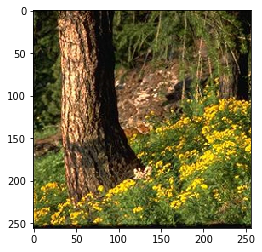

In [6]:
# testing to make sure the labels and images stored correctly
plt.imshow(images[30]);
print(labels[30])

mountain


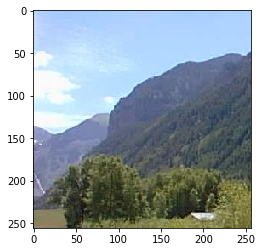

In [7]:
plt.imshow(images[-1]);
print(labels[-1])

In [9]:
# converting labels to numeric
# mountain = 1, forest = 0

num_labels = []

for l in labels:
    if l == 'mountain':
        num_labels.append(1)
    else:
        num_labels.append(0)

In [10]:
type(images[0][0][0][0])

numpy.uint8

In [11]:
# converting image arrays to numpy arrays

np_images = [np.asarray(i) for i in images]
type(np_images[0])

numpy.ndarray

In [12]:
type(np_images)

list

In [14]:
# Normalize values

np_images = np.asarray(np_images) / np.asarray(np_images).max()
type(np_images[0][0][0][0])

numpy.float64

In [23]:
# Binary classification
NUM_CLASSES = 2

# Fixed for color images
CHANNELS = 3


IMAGE_RESIZE = 256
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'binary_crossentropy' 

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [ ]:
# # Specifying model

# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense

# res = ResNet50(input_shape = (256,256,3), include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet')

# for layer in res.layers:
#     layer.trainable = False

# x = res.output
# x = Dense(100, activation = 'relu')(x)
# x = Dense(50, activation = 'relu')(x)

# # model.add(Dense(100, activation = 'relu'))
# # model.add(Dense(50, activation = 'relu'))

# # 2nd layer as Dense for binary classification
# predictions = (Dense(1, activation = 'sigmoid'))
# model = Model(res.input, predictions)

In [40]:
# Specifying model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for binary classification
model.add(Dense(1, activation = 'sigmoid'))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [41]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [42]:
# Compiling model
model.compile(optimizer = 'adam', loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [43]:
# Training model

model.fit(np_images,np.asarray(num_labels))

Train on 702 samples
702/702 [==============================] - 285s 406ms/sample - loss: 0.4248 - accuracy: 0.7963


In [ ]:
# Accuracy = .79

# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language